**OlabisiDS Notebook**

Libraries import / Environment Set-Up

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
comment_df = pd.read_csv("/content/final_hateXplain[1].csv")
comment_df.head()

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,NaN
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN
3,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,NaN
4,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,NaN


In [3]:
comment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20109 entries, 0 to 20108
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             20109 non-null  object
 1   label               20109 non-null  object
 2   Race                20109 non-null  object
 3   Religion            20109 non-null  object
 4   Gender              20109 non-null  object
 5   Sexual Orientation  20109 non-null  object
 6   Miscellaneous       3533 non-null   object
dtypes: object(7)
memory usage: 1.1+ MB


In [4]:
comment_df.duplicated().sum()

0

In [5]:
comment_df.isnull().sum()

comment                   0
label                     0
Race                      0
Religion                  0
Gender                    0
Sexual Orientation        0
Miscellaneous         16576
dtype: int64

In [6]:
comment_df["Miscellaneous"].nunique()

5

In [7]:
comment_df["Miscellaneous"].unique()

array([nan, 'Other', 'Disability', 'Refugee', 'Minority', 'Economic'],
      dtype=object)

In [8]:
#Dropping Miscellaneous column
comment_df = comment_df.drop(['Miscellaneous'], axis=1)

In [9]:
#Checking label frequencies
grouped_l = comment_df.groupby("label").count()
grouped_l["comment"]

label
hatespeech    6484
normal        7818
offensive     5807
Name: comment, dtype: int64

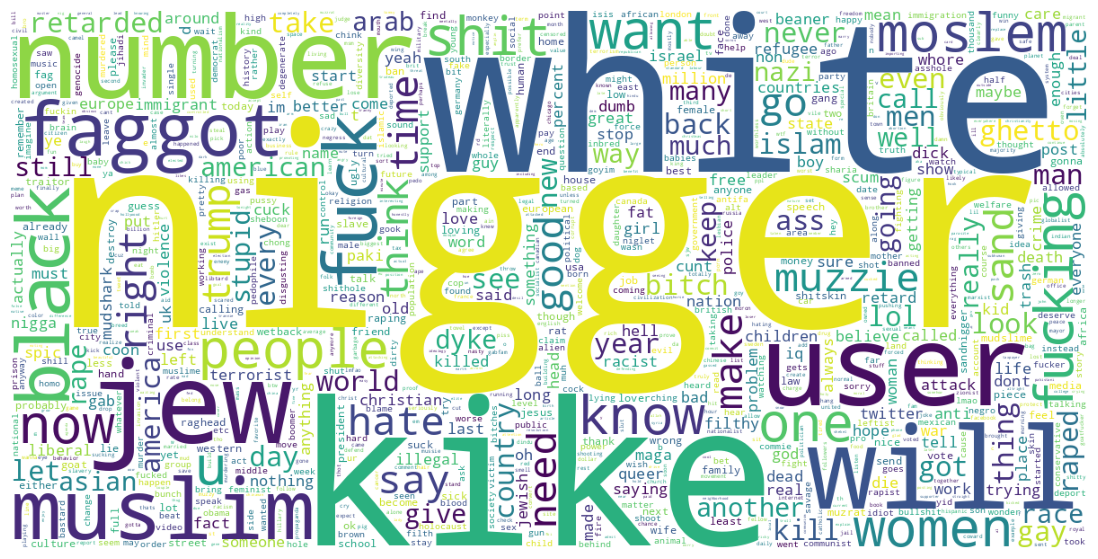

In [10]:
#Wordcloud for hatespeech
hatespeech = comment_df[comment_df['label'] == 'hatespeech']
text = " ".join(i for i in hatespeech.comment)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show();

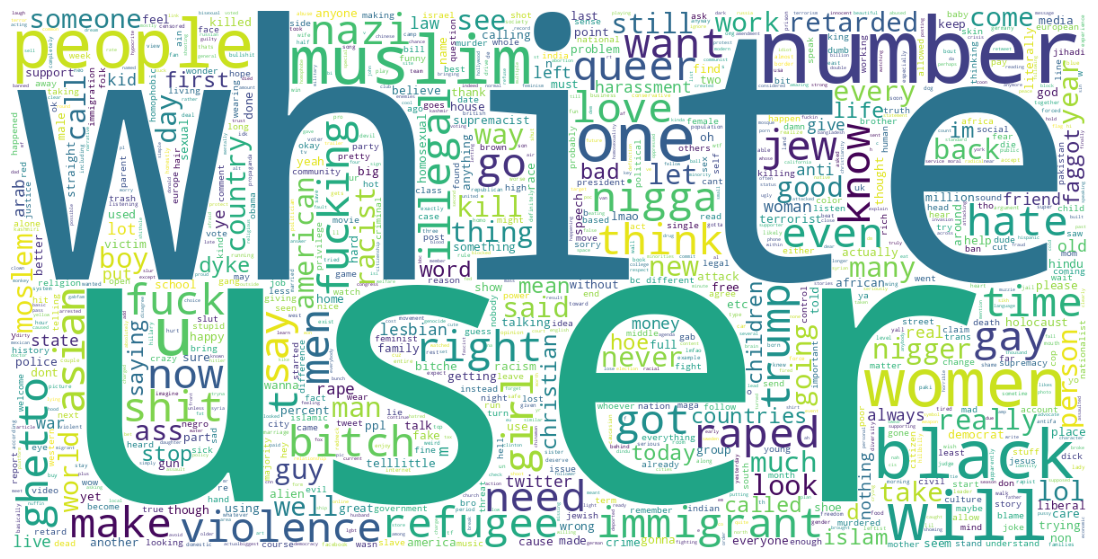

In [11]:
#Wordcloud for normal speech
normal = comment_df[comment_df['label'] == 'normal']
text = " ".join(i for i in normal.comment)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show();

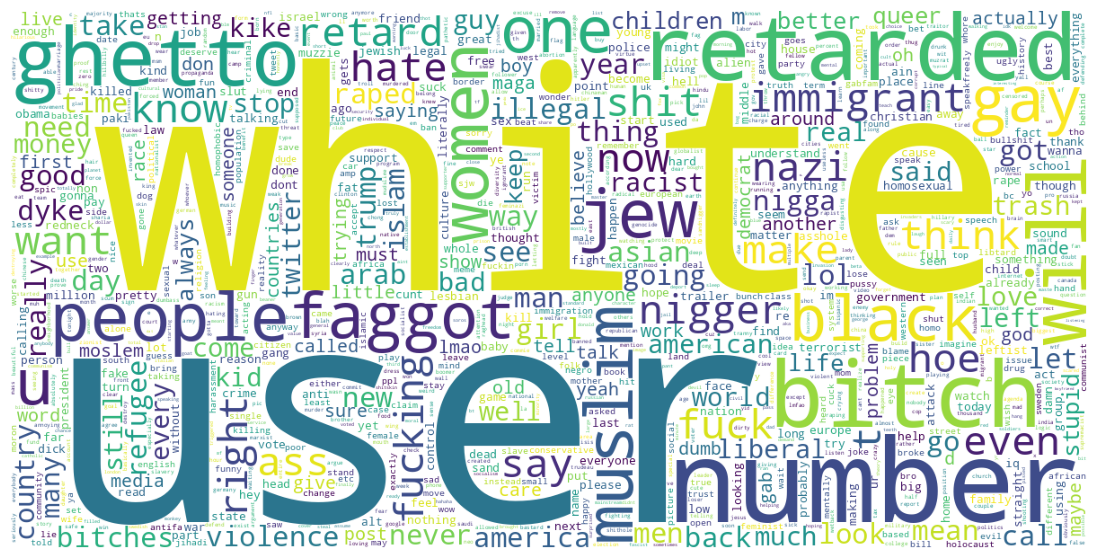

In [12]:
#Wordcloud for offensive speech
offensive = comment_df[comment_df['label'] == 'offensive']
text = " ".join(i for i in offensive.comment)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show();

Preprocesing

In [13]:
#convert uppercase letters to lowercase letters
comment_df["comment"] = comment_df["comment"].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [14]:
#delete punctuation marks
comment_df["comment"] = comment_df["comment"].str.replace('[^\w\s]','')

In [15]:
#delete numbers
comment_df["comment"] = comment_df["comment"].str.replace('\d+', '')

In [16]:
#delete stopwords
stop_words = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

comment_df["comment"] = comment_df["comment"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [17]:
#lemmatization. That is, we get the roots of the words
comment_df["comment"] = comment_df["comment"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [18]:
#remove URLs if there are any in the comments
comment_df["comment"] = comment_df["comment"].apply(lambda x: " ".join(re.sub(r'http\S+', '', x) for x in x.split()))

In [19]:
#Looking at dataset latet version
comment_df.head()

,comment,label,Race,Religion,Gender,Sexual Orientation
0,0 u0 lmao wow fuck 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation
1,1 0 th floor maybe wow cnn fakenews body count...,offensive,No_race,Nonreligious,No_gender,No_orientation
2,1 0 yr <number> white woman raped nigger <numb...,hatespeech,African,Nonreligious,No_gender,No_orientation
3,1 2 h ago ching chong accepted friend request ❤️,offensive,Asian,Nonreligious,No_gender,No_orientation
4,1 8 th century mayhem lawlessness nothing loud...,normal,No_race,Nonreligious,No_gender,No_orientation


In [20]:
#Get every words from dataset and append them to 'corpus' list
corpus = []
for i in comment_df.comment:
    for j in i.split():
        corpus.append(j.strip())

#count the words
counter = Counter(corpus)
common_words = counter.most_common(15)
dict(common_words)

{'<user>': 7429,
 'white': 4290,
 '<number>': 3075,
 'nigger': 2830,
 'like': 2144,
 'woman': 1823,
 'people': 1730,
 'muslim': 1546,
 'jew': 1489,
 'black': 1350,
 'get': 1318,
 'bitch': 1317,
 'u': 1193,
 'one': 1174,
 'kike': 1159}

Modelling

In [21]:
#Turning the following columns to numeric Race, Religion,  Gender, Sexual Orientation

lb = LabelBinarizer()
comment_df['Race'] = lb.fit_transform(comment_df['Race'])
comment_df['Religion'] = lb.fit_transform(comment_df['Religion'])
comment_df['Gender'] = lb.fit_transform(comment_df['Gender'])
comment_df['Sexual Orientation'] = lb.fit_transform(comment_df['Sexual Orientation'])

In [22]:
#Encoding label column

comment_df['label'] = comment_df['label'].map({'hatespeech': 0, 'normal': 1, 'offensive': 2})

In [23]:
#Split the dataset into features (X) and target variable (y)
X = comment_df.drop('label', axis=1)
y = comment_df['label']

#Split the data into training and temporary set (test + validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (16087, 5)
y_train shape: (16087,)
X_test shape: (4022, 5)
y_test shape: (4022,)


In [24]:
tokenizer = Tokenizer(num_words=20)
tokenizer.fit_on_texts(X_train['comment'])

#Convert text to sequences
tokenized_train = tokenizer.texts_to_sequences(X_train['comment'])
tokenized_test = tokenizer.texts_to_sequences(X_test['comment'])

#Pad sequences to a fixed length
max_length = 10
X_train_padded = sequence.pad_sequences(tokenized_train, maxlen=max_length)
X_test_padded = sequence.pad_sequences(tokenized_test, maxlen=max_length)

In [25]:
#Building LSTM model
model = Sequential()
model.add(Embedding(10000, 128, input_length=max_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

#Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Define a learning rate scheduler
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

#Train the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, callbacks=[learning_rate_reduction])


Epoch 1/10
503/503 [==============================] - ETA: 0s - loss: 0.9461 - accuracy: 0.5353

503/503 [==============================] - 38s 64ms/step - loss: 0.9461 - accuracy: 0.5353 - lr: 0.0010
Epoch 2/10
503/503 [==============================] - ETA: 0s - loss: 0.9221 - accuracy: 0.5549

503/503 [==============================] - 32s 64ms/step - loss: 0.9221 - accuracy: 0.5549 - lr: 0.0010
Epoch 3/10
503/503 [==============================] - ETA: 0s - loss: 0.9157 - accuracy: 0.5557

503/503 [==============================] - 33s 66ms/step - loss: 0.9157 - accuracy: 0.5557 - lr: 0.0010
Epoch 4/10
502/503 [============================>.] - ETA: 0s - loss: 0.9138 - accuracy: 0.5566

503/503 [==============================] - 32s 63ms/step - loss: 0.9138 - accuracy: 0.5567 - lr: 0.0010
Epoch 5/10
503/503 [==============================] - ETA: 0s - loss: 0.9121 - accuracy: 0.5583

503/503 [==============================] - 35s 69ms/step - loss: 0.9121 - accuracy: 0.5583 - lr: 0.0010
Epoch 6/10
502/503 [============================>.] - ETA: 0s - loss: 0.9099 - accuracy: 0.5589

503/503 [==============================] - 35s 70ms/step - loss: 0.9099 - accuracy: 0.5588 - lr: 0.0010
Epoch 7/10
502/503 [============================>.] - ETA: 0s - loss: 0.9087 - accuracy: 0.5578

503/503 [==============================] - 32s 65ms/step - loss: 0.9088 - accuracy: 0.5578 - lr: 0.0010
Epoch 8/10
503/503 [==============================] - ETA: 0s - loss: 0.9076 - accuracy: 0.5593

503/503 [==============================] - 32s 64ms/step - loss: 0.9076 - accuracy: 0.5593 - lr: 0.0010
Epoch 9/10
502/503 [============================>.] - ETA: 0s - loss: 0.9055 - accuracy: 0.5575

503/503 [==============================] - 32s 63ms/step - loss: 0.9057 - accuracy: 0.5573 - lr: 0.0010
Epoch 10/10
502/503 [============================>.] - ETA: 0s - loss: 0.9040 - accuracy: 0.5593

503/503 [==============================] - 31s 62ms/step - loss: 0.9041 - accuracy: 0.5591 - lr: 0.0010


In [26]:
#Evaluate the model on the training set
train_accuracy = model.evaluate(X_train_padded, y_train, verbose=0)
print('Train Accuracy: {}'.format(train_accuracy))

Train Accuracy: [0.8985787630081177, 0.5628768801689148]


In [27]:
#Evaluate the model on the test set
accuracy = model.evaluate(X_test_padded, y_test)
print('Accuracy: {}'.format(accuracy))

#Make predictions on the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

#Print classification report and confusion matrix
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

126/126 [==============================] - 1s 10ms/step - loss: 0.9265 - accuracy: 0.5490
Accuracy: [0.9265235066413879, 0.5489805936813354]
126/126 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.75      0.48      0.59      1325
           1       0.50      0.82      0.62      1502
           2       0.49      0.28      0.35      1195

    accuracy                           0.55      4022
   macro avg       0.58      0.53      0.52      4022
weighted avg       0.58      0.55      0.53      4022

[[ 639  526  160]
 [  74 1238  190]
 [ 136  728  331]]


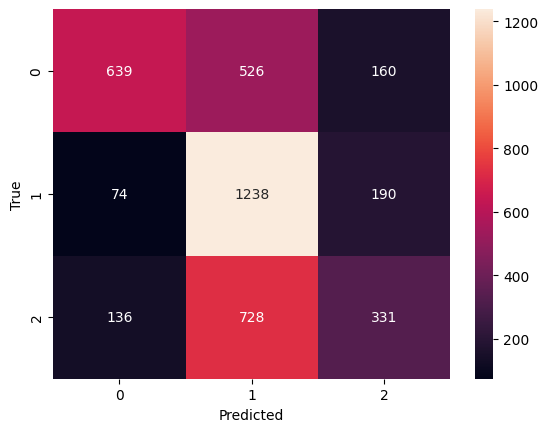

In [28]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()